### Student Information

Name:`馬茂源 (Brian Ma)`

Student ID:`107062549`

GitHub ID:`brian41005`

---

### Instructions

- First, you should attempt the **take home** exercises provided in the [notebook](https://github.com/omarsar/data_mining_lab/blob/master/news_data_mining.ipynb) we used for the first lab session. Attempt all the exercises, as it is counts towards the final grade of your first assignment (20%). 

- Then, you are asked to apply each of the data exploration and data operation steps learned in the [first lab session](https://github.com/omarsar/data_mining_lab) on **the new dataset**. This part is worth 30% of your grade!

- In addition to applying the same operations from the first lab, we are asking that you attempt the following tasks on the new sentiment dataset as well (40%):
    - **new data visualizations**
    - Generate **TF-IDF features** from the tokens of each text. 
    - Using both the TF-IDF and word frequency features, try to compute the **similarity** between random sentences and report results.  Try to explore a few of them in this exercise and report the differences in result. 
    -  **Naive Bayes classifier**  use both the TF-IDF features and word frequency features to build two seperate classifiers.  

- Presentation matters! You are also expected to **tidy up your notebook** and attempt new data operations and techniques that you have learned so far in the Data Mining course. Surprise us! This segment is worth 10% of your grade.


[home exercises](news_data_mining.ipynb)

In [1]:
### Begin Assignment Here!

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [3]:
file_list = ['imdb_labelled', 'yelp_labelled' , 'amazon_cells_labelled']

In [4]:
sentiment_df = pd.concat([pd.read_csv('sentiment labelled sentences/{}.txt'.format(f_name), 
                                      sep=sep,
                                      header=None)  
                          for f_name, sep in zip(file_list, [' \t', '\t', '\t'])])
sentiment_df.columns = ['text', 'score']

c:\python36\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [5]:
sentiment_df['score'].isna().sum()

0

In [6]:
sentiment_df['score'] = sentiment_df['score'].astype(int)
sentiment_df.head()

,text,score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
assert len(sentiment_df) == 3000

In [8]:
sentiment_df[['score']].describe()

,score
count,3000.000000
mean,0.500000
std,0.500083
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


## Check Missing values(Preprocessing)

In [9]:
sentiment_df.isnull().sum()

text     0
score    0
dtype: int64

In [10]:
sentiment_df['text'].apply(lambda t: t == None 
                           and t == np.nan 
                           and t == '').sum()

0

In [11]:
sentiment_df['score'].apply(lambda s: not(s == 0 or s == 1)).sum()

0

## Duplicate Data(Preprocessing)

In [12]:
sentiment_df.duplicated('text').sum()

17

In [13]:
sentiment_df['text'][sentiment_df.duplicated('text', False)]

90                       Definitely worth checking out. 
125                                               10/10 
363                      Definitely worth checking out. 
572                                    Not recommended. 
585                                    Not recommended. 
788                                               10/10 
334                                   I love this place.
380                                     I won't be back.
383                               The food was terrible.
505                    I would not recommend this place.
814                                   I love this place.
816                               The food was terrible.
843                                     I won't be back.
846                    I would not recommend this place.
18                                         Works great!.
179    If you like a loud buzzing to override all you...
180                              Don't buy this product.
187                            

In [14]:
sentiment_df.drop_duplicates('text', inplace=True)

In [15]:
len(sentiment_df) == 2983

True

0    1493
1    1490
Name: score, dtype: int64


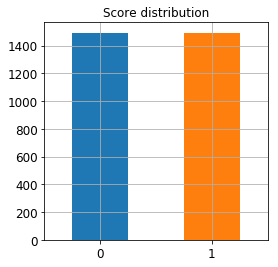

In [16]:
value_counts = sentiment_df['score'].value_counts()
print(value_counts)
value_counts.plot(kind = 'bar',
                  grid=True,
                  title = 'Score distribution',
                  rot = 0, fontsize = 12, figsize = (4, 4))
#dataset is balance.

## Generate  features

In [17]:
import nltk, re

In [18]:
def tokenize_text(text, remove_stopwords=False):
    """
    Tokenize text using the nltk library
    """
    tokens = [word for d in nltk.sent_tokenize(text, language='english') 
              for word in nltk.word_tokenize(d, language='english')]
    return tokens

In [19]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize

In [20]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

### TF-IDF

In [21]:
from nltk.corpus import stopwords

In [22]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=2, 
                                   max_df=0.95,
                                   #token_pattern=r'(\S+)'
                                   #tokenizer=tokenize_text
                                   #max_features=5000,
                                   #stop_words=stopwords.words('english')
                                  )

In [23]:
X_tfidf = tfidf_vectorizer.fit_transform(sentiment_df['text'])
X_tfidf.shape

(2983, 6759)

#### tfidf-document matrix

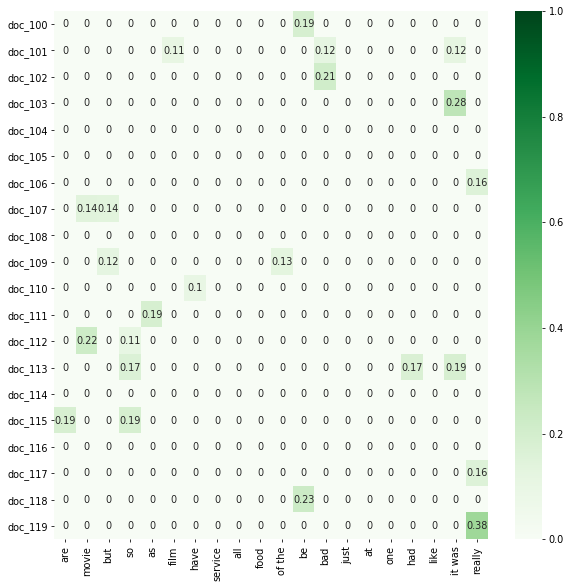

In [24]:
doc_idx = slice(100, 120)
#find those world whose mean tfidf values are high
words_idx = np.argsort(np.mean(X_tfidf, axis=0).tolist()[0])[::-1][20:40]

plot_x = [tfidf_vectorizer.get_feature_names()[i] for i in words_idx]
plot_y = ["doc_"+ str(i) for i in list(sentiment_df.index)[doc_idx]]
plot_z = X_tfidf[doc_idx, words_idx].toarray()

df_todraw = pd.DataFrame(plot_z, 
                         columns=plot_x, 
                         index=plot_y)

plt.subplots(figsize=(10, 10), dpi=70)
sns.heatmap(df_todraw, vmin=0, vmax=1, annot=True, cmap="Greens")

#### TF-IDF CO-Similarity  Visualizations

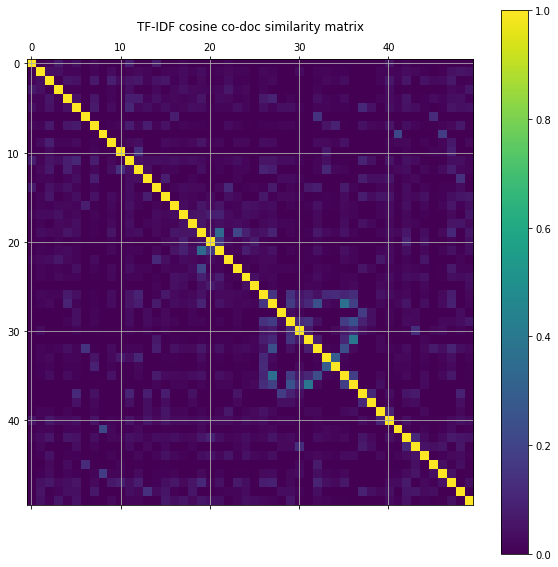

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cosine_similarity(X_tfidf)[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF-IDF cosine co-doc similarity matrix')
fig.colorbar(cax)
plt.show()

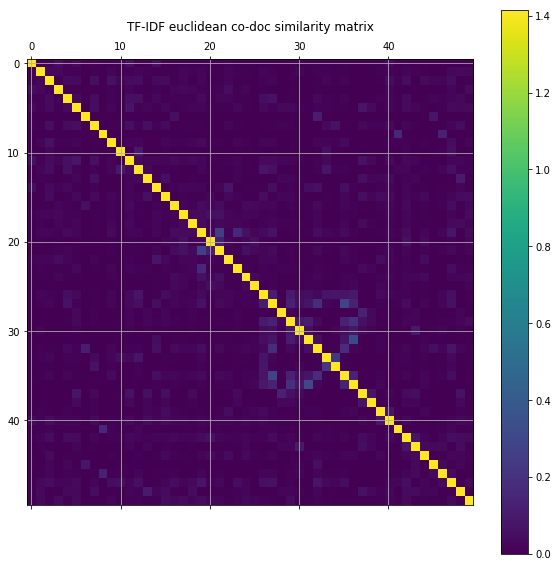

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(np.sqrt(2) - euclidean_distances(X_tfidf)[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF-IDF euclidean co-doc similarity matrix')
fig.colorbar(cax)
plt.show()

### TF features

In [27]:
tf_vectorizer = CountVectorizer()
X_tf = tf_vectorizer.fit_transform(sentiment_df['text'])
#X_tf = normalize(X_tf, axis=1)
X_tf.shape

(2983, 5155)

In [28]:
term_frequencies = np.asarray(X_tf.sum(axis=0))[0]

In [29]:
def plot_word_frequency(word_list, plot_title):
    trace1 = {
        "x": list(word_list[0]),
        "y": list(word_list[1]),
        "type": "bar"
    }

    data = go.Data([trace1])

    layout = {
        "title": plot_title,
        "yaxis": {"title": "Frequency"},
        'xaxis':{'title':'word'}
    }

    fig = go.Figure(data=data, layout=layout)
    return fig

In [30]:
words_idx = np.argsort(np.sum(X_tf, axis=0).tolist()[0])[::-1][:300]
iplot(plot_word_frequency([np.array(tf_vectorizer.get_feature_names())[words_idx], 
                                         term_frequencies[words_idx]], 
                                        'Term Frequencies'))

In [31]:
words_idx = np.argsort(np.sum(X_tf, axis=0).tolist()[0])[::-1][:300]
iplot(plot_word_frequency([np.array(tf_vectorizer.get_feature_names())[words_idx], 
                                         np.log2(term_frequencies[words_idx])], 
                                        'Term Frequencies(log_2)'))

#### tf-document matrix

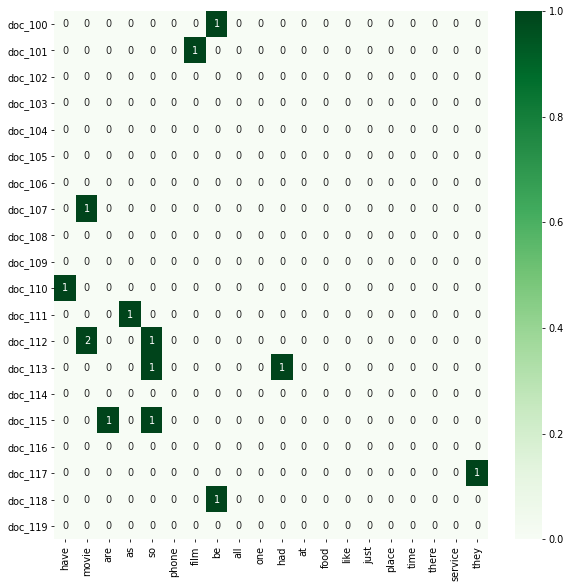

In [32]:
doc_idx = slice(100, 120)
words_idx = np.argsort(np.sum(X_tf, axis=0).tolist()[0])[::-1][20:40]

plot_x = [tf_vectorizer.get_feature_names()[i] for i in words_idx]
plot_y = ["doc_"+ str(i) for i in list(sentiment_df.index)[doc_idx]]
plot_z = X_tf[doc_idx, words_idx].toarray()

df_todraw = pd.DataFrame(plot_z, 
                         columns=plot_x, 
                         index=plot_y)

plt.subplots(figsize=(10, 10), dpi=70)
sns.heatmap(df_todraw, vmin=0, vmax=1, annot=True, cmap="Greens")

#### TF Similarity visualizations

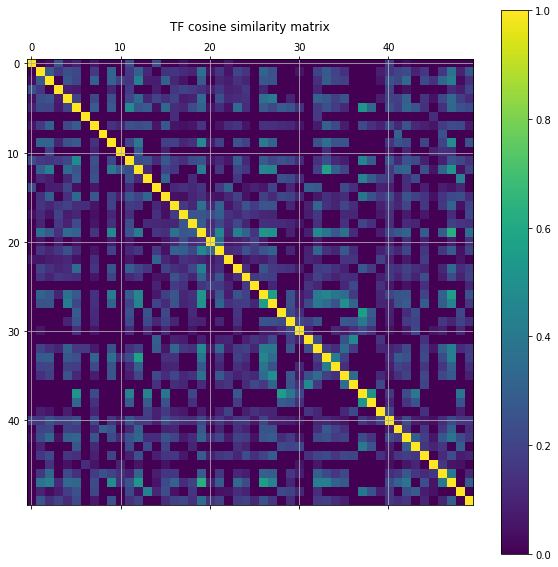

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cosine_similarity(X_tf)[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF cosine similarity matrix')
fig.colorbar(cax)
plt.show()

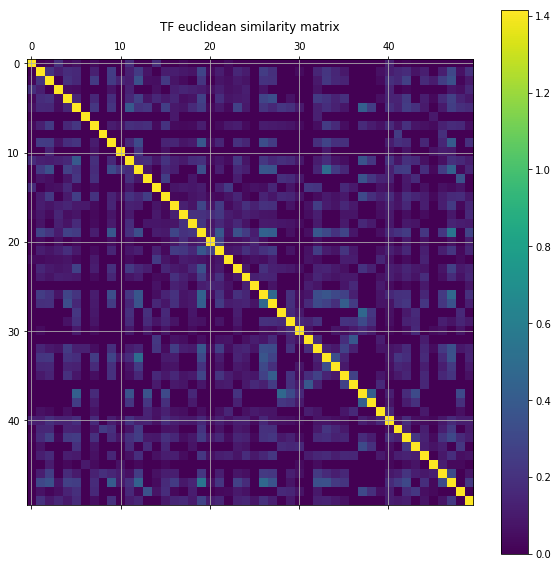

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(np.sqrt(2) - euclidean_distances(normalize(X_tf, axis=1))[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF euclidean similarity matrix')
fig.colorbar(cax)
plt.show()

## Visualizations

In [35]:
from sklearn.decomposition import KernelPCA, TruncatedSVD, FactorAnalysis, PCA

### Word Cloud

In [36]:
from wordcloud import WordCloud

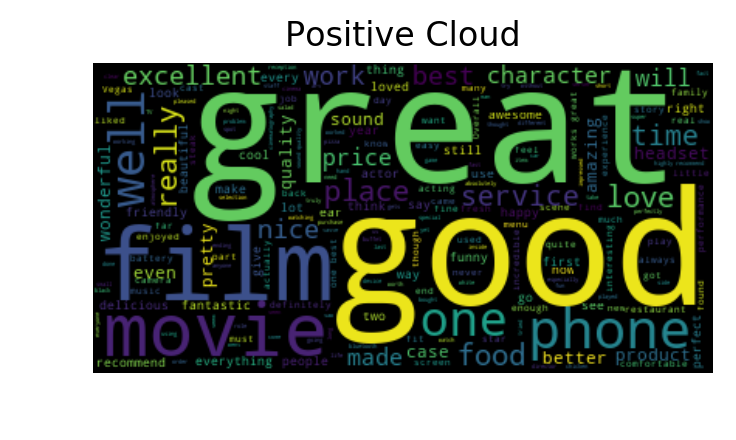

In [37]:
word_cloud = WordCloud().generate(' '.join(sentiment_df['text'][sentiment_df['score'] == 1].values.tolist()))
plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Cloud')
plt.show()

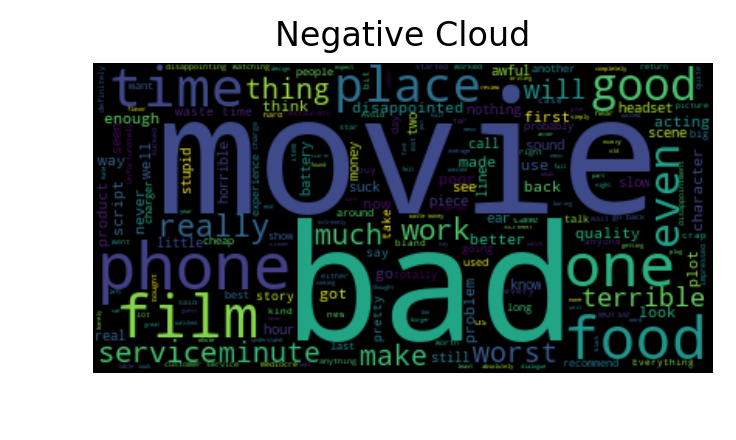

In [38]:
word_cloud = WordCloud().generate(' '.join(sentiment_df['text'][sentiment_df['score'] == 0].values.tolist()))
plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Cloud')
plt.show()

### Dimension reduction

#### TF-IDF

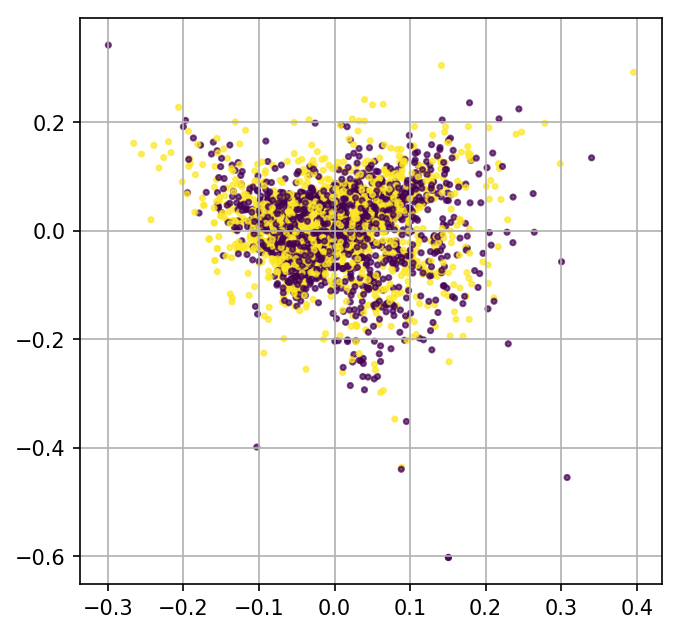

In [39]:
#TF IDF
X_tfidf_reduced = KernelPCA(n_components=2, random_state=42).fit_transform(X_tfidf.toarray())
plt.figure(figsize=(5, 5), dpi=150)
plt.grid(True)
plt.scatter(X_tfidf_reduced[:, 0], X_tfidf_reduced[:, 1], 
            c=sentiment_df['score'].values.tolist(),
            s=6, alpha=0.7)

In [40]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [41]:
#Reduce to 3D
X_tfidf_reduced_3d = KernelPCA(n_components=3).fit_transform(X_tfidf.toarray())

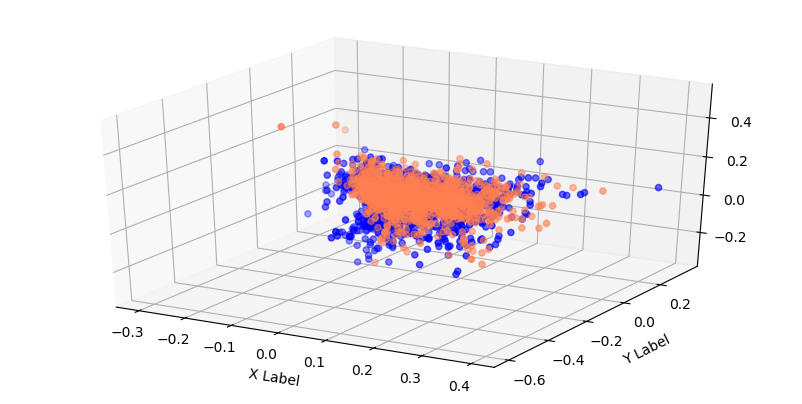

In [42]:
col = ['coral', 'blue']

# plot
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111, projection='3d')

for c, category in zip(col, [0, 1]):
    xs = X_tfidf_reduced_3d[sentiment_df['score'] == category].T[0]
    ys = X_tfidf_reduced_3d[sentiment_df['score'] == category].T[1]
    zs = X_tfidf_reduced_3d[sentiment_df['score'] == category].T[2]
    ax.scatter(xs, ys, zs, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')

plt.show()

#### TF

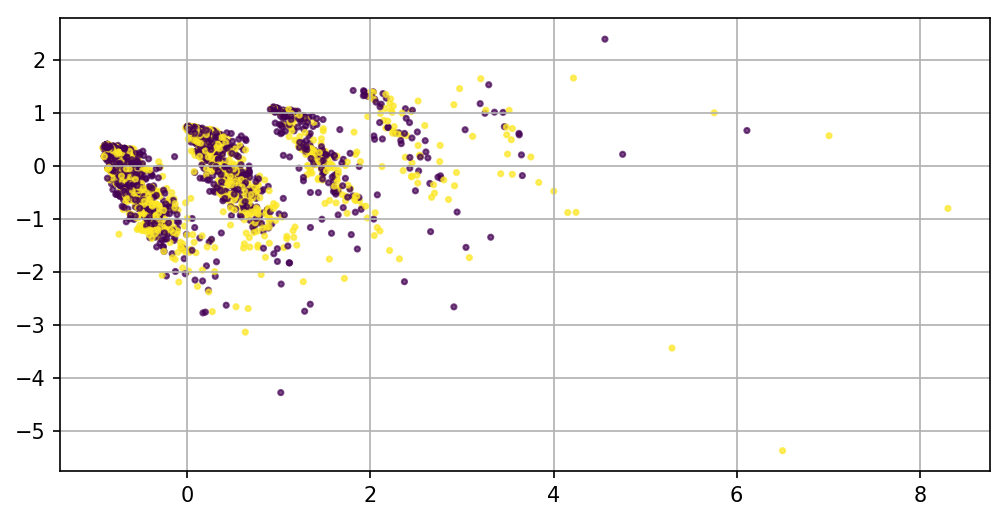

In [43]:
#TF
X_tf_reduced = KernelPCA(n_components=2, random_state=42).fit_transform(X_tf.toarray())
plt.figure(figsize=(8, 4), dpi=150)
plt.grid(True)
plt.scatter(X_tf_reduced[:, 0], X_tf_reduced[:, 1], 
            c=sentiment_df['score'].values.tolist(),
            s=6, alpha=0.7)

In [44]:
#Reduce to 3D
X_tf_reduced_3d = KernelPCA(n_components=3).fit_transform(X_tf.toarray())

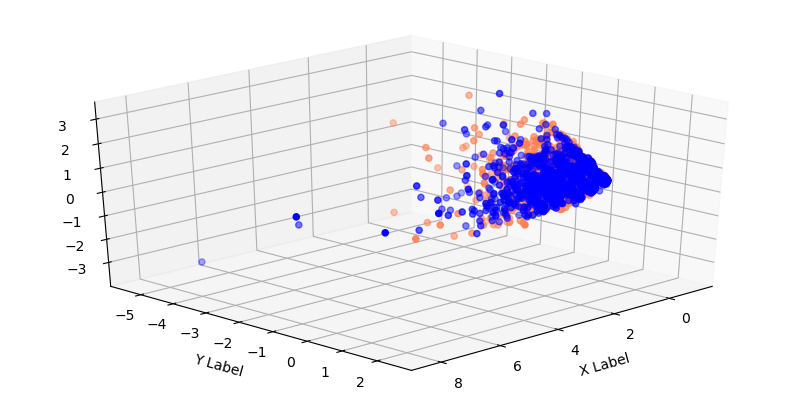

In [45]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111, projection='3d')

col = ['coral', 'blue']
ax.view_init(30, 45)
for c, category in zip(col, [0, 1]):
    xs = X_tf_reduced_3d[sentiment_df['score'] == category].T[0]
    ys = X_tf_reduced_3d[sentiment_df['score'] == category].T[1]
    zs = X_tf_reduced_3d[sentiment_df['score'] == category].T[2]
    ax.scatter(xs, ys, zs, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')

plt.show()

## Classifying 

In [46]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder

In [47]:
X_tfidf_dense = X_tfidf.toarray()
X_tf_dense = X_tf.toarray()

In [48]:
#y = OneHotEncoder().fit_transform(sentiment_df['score'].values.reshape(-1, 1)).toarray()
y = sentiment_df['score'].values

In [49]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
tfidf_model = MultinomialNB()
tf_model = MultinomialNB()

### TF-IDF

In [51]:
print('acc:{:.3f}'.format(cross_val_score(tfidf_model, X_tfidf_dense, y, scoring='accuracy', cv=10).mean()))

acc:0.830


In [52]:
y_pred = cross_val_predict(tfidf_model, X_tfidf_dense, y, cv=10, method='predict')
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.86      0.83      1493
          1       0.85      0.80      0.82      1490

avg / total       0.83      0.83      0.83      2983



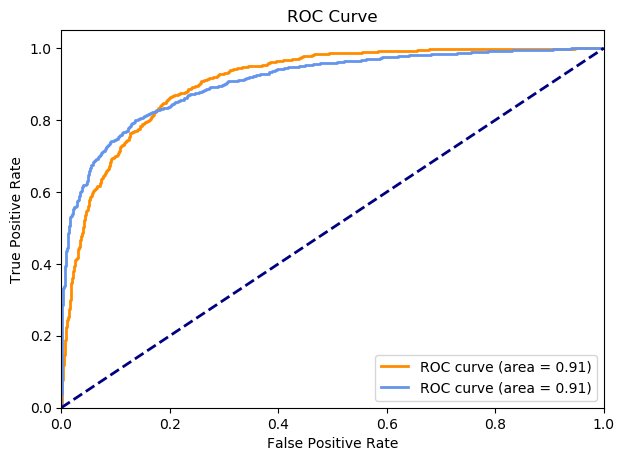

In [53]:
y_pred = cross_val_predict(tfidf_model, X_tfidf_dense, y, cv=10, method='predict_proba')
plt.figure(figsize=(7, 5), dpi=100)
lw = 2
for c, color in [(0, 'darkorange'), (1,  'cornflowerblue')]:
    fpr, tpr, _ = roc_curve(y, y_pred[:, c], pos_label=c)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color,
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

在經過不同的ngram_range, min_df, max_df數值嘗試後，以tf_idf為特徵的model事實上可以獲得與tf model差不多的結果，其他的參數組合多是產生比tf model精準度差的結果(多半是少tf model 0.01~0.05的精準度)，綜合來說tf-idf model的精準度較容易受到ngram_range, min_df, max_df參數的影響

### TF

In [54]:
print('acc:{:.3f}'.format(cross_val_score(tf_model, X_tf_dense, y, scoring='accuracy', cv=10).mean()))

acc:0.821


In [55]:
y_pred = cross_val_predict(tf_model, X_tf_dense, y, cv=10)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.85      0.83      1493
          1       0.84      0.79      0.82      1490

avg / total       0.82      0.82      0.82      2983



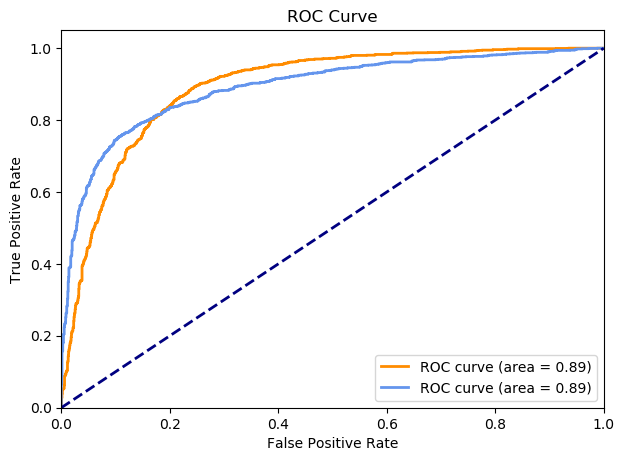

In [56]:
y_pred = cross_val_predict(tf_model, X_tf_dense, y, cv=10, method='predict_proba')
plt.figure(figsize=(7, 5), dpi=100)
lw = 2
for c, color in [(0, 'darkorange'), (1,  'cornflowerblue')]:
    fpr, tpr, _ = roc_curve(y, y_pred[:, c], pos_label=c)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color,
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Look error


In [57]:
tf_idf_model_result = pd.DataFrame()
tf_model_result = pd.DataFrame()

In [58]:
tf_idf_model_result['score'] = sentiment_df['score']
tf_idf_model_result['y_pred'] = cross_val_predict(tfidf_model, X_tfidf_dense, y, cv=10)
tf_idf_model_result['is_error'] = tf_idf_model_result['y_pred'] != tf_idf_model_result['score']
tf_idf_model_result['text_len'] = sentiment_df['text'].apply(lambda x: len(x.split()))

In [59]:
tf_model_result['score'] = sentiment_df['score']
tf_model_result['y_pred'] = cross_val_predict(tf_model, X_tf_dense, y, cv=10)
tf_model_result['is_error'] = tf_model_result['y_pred'] != tf_model_result['score']
tf_model_result['text_len'] = sentiment_df['text'].apply(lambda x: len(x.split()))

### Tf-idf model

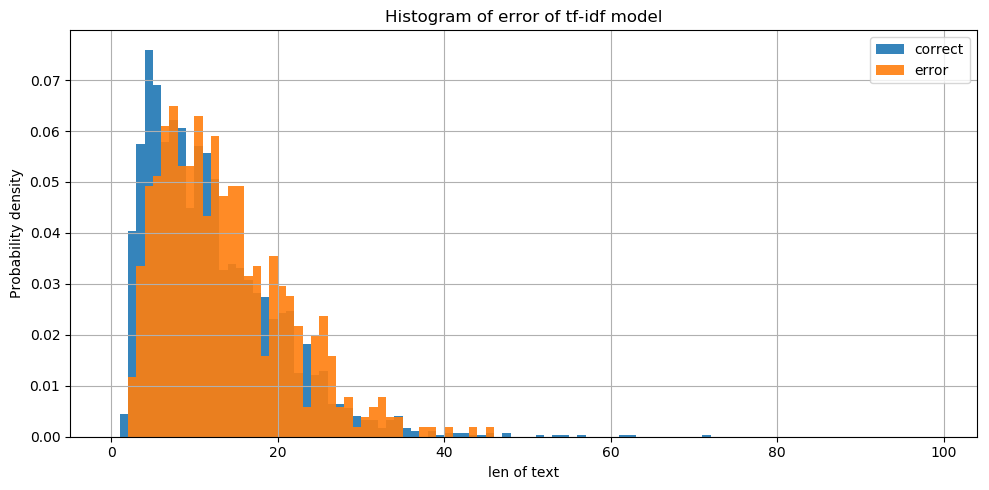

In [60]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

num_bins = range(0, 100, 1)
# the histogram of the data
ax.hist(tf_idf_model_result['text_len'][tf_idf_model_result['is_error'] == 0], 
        num_bins, density=1, label='correct', alpha=0.9)
ax.hist(tf_idf_model_result['text_len'][tf_idf_model_result['is_error'] == 1], 
        num_bins, density=1, label='error', alpha=0.9)

ax.set_xlabel('len of text')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of error of tf-idf model')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

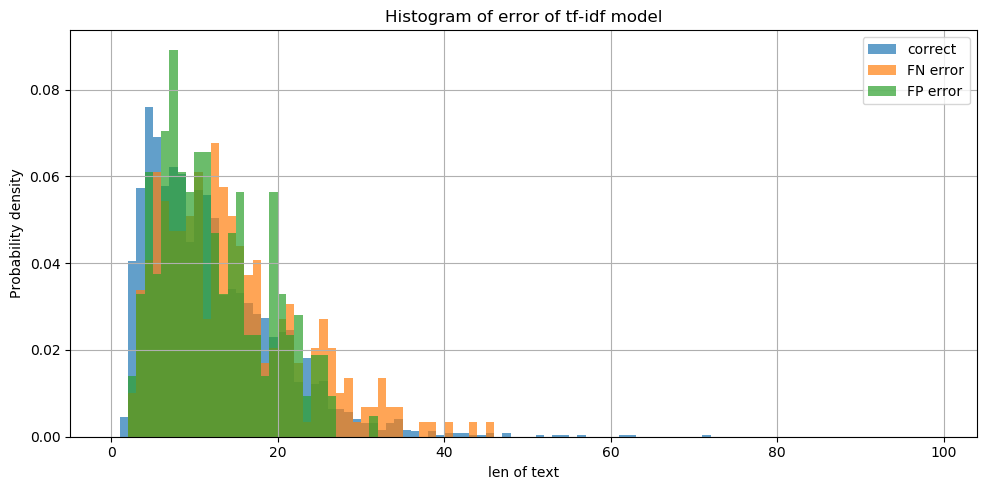

In [61]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

num_bins = range(0, 100, 1)
# the histogram of the data
ax.hist(tf_idf_model_result['text_len'][tf_idf_model_result['is_error'] == 0], 
        num_bins, density=1, label='correct', alpha=0.7)
ax.hist(tf_idf_model_result['text_len'][(tf_idf_model_result['score'] == 1) & tf_idf_model_result['is_error'] == 1], 
        num_bins, density=1, label='FN error', alpha=0.7)
ax.hist(tf_idf_model_result['text_len'][(tf_idf_model_result['score'] == 0) & tf_idf_model_result['is_error'] == 1], 
        num_bins, density=1, label='FP error', alpha=0.7)

ax.set_xlabel('len of text')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of error of tf-idf model')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

### Tf model

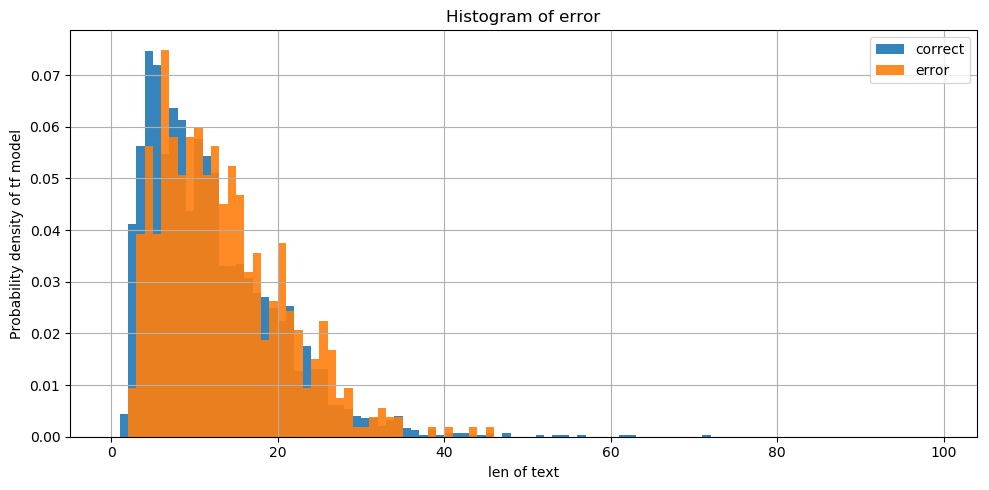

In [62]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

num_bins = range(0, 100, 1)
# the histogram of the data
ax.hist(tf_model_result['text_len'][tf_model_result['is_error'] == 0], 
        num_bins, density=1, label='correct', alpha=0.9)
ax.hist(tf_model_result['text_len'][tf_model_result['is_error'] == 1], 
        num_bins, density=1, label='error', alpha=0.9)

ax.set_xlabel('len of text')
ax.set_ylabel('Probability density of tf model')
ax.set_title('Histogram of error')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

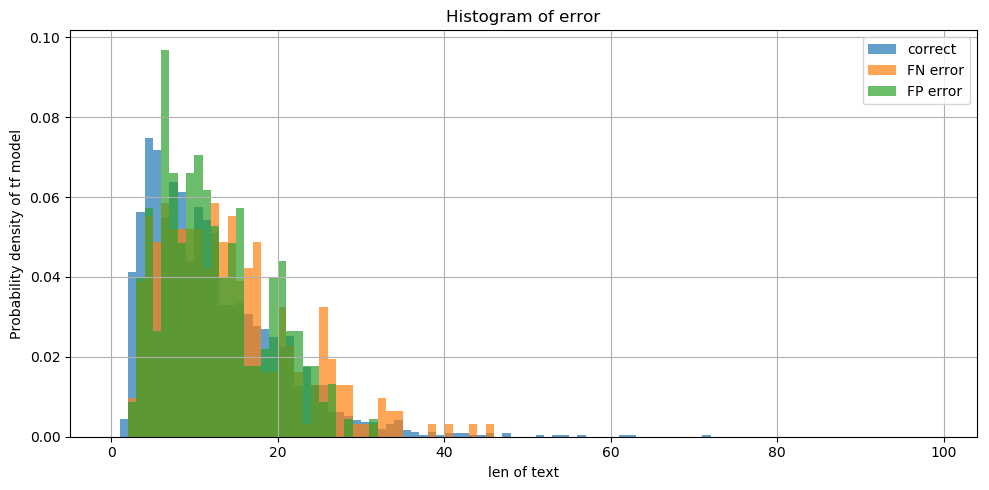

In [63]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

num_bins = range(0, 100, 1)
# the histogram of the data
ax.hist(tf_model_result['text_len'][tf_model_result['is_error'] == 0], num_bins, density=1, label='correct', alpha=0.7)
ax.hist(tf_model_result['text_len'][(tf_model_result['score'] == 1) & tf_model_result['is_error'] == 1], 
        num_bins, density=1, label='FN error', alpha=0.7)
ax.hist(tf_model_result['text_len'][(tf_model_result['score'] == 0) & tf_model_result['is_error'] == 1], 
        num_bins, density=1, label='FP error', alpha=0.7)

ax.set_xlabel('len of text')
ax.set_ylabel('Probability density of tf model')
ax.set_title('Histogram of error')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

### Two model error distribution comparison

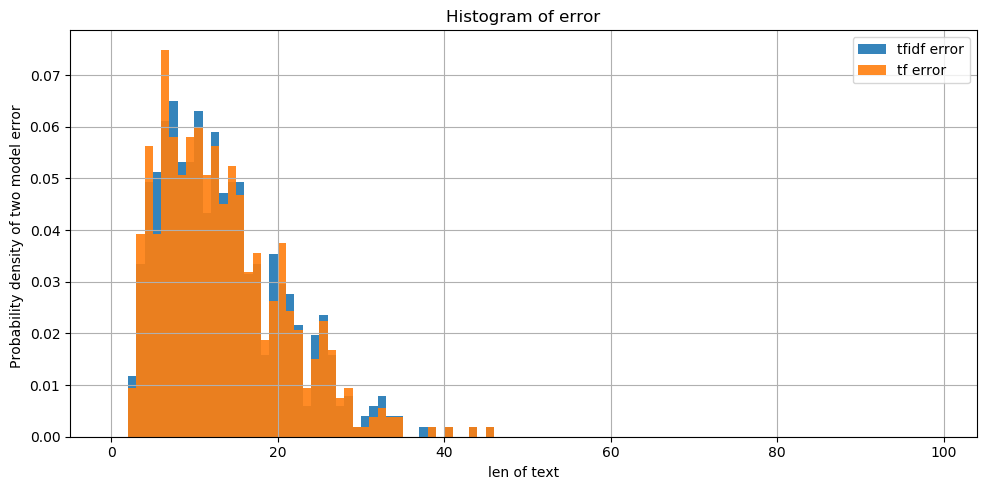

In [64]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

num_bins = range(0, 100, 1)
# the histogram of the data
ax.hist(tf_idf_model_result['text_len'][tf_idf_model_result['is_error'] == 1], 
        num_bins, density=1, label='tfidf error', alpha=0.9)
ax.hist(tf_model_result['text_len'][tf_model_result['is_error'] == 1], 
        num_bins, density=1, label='tf error', alpha=0.9)

ax.set_xlabel('len of text')
ax.set_ylabel('Probability density of two model error ')
ax.set_title('Histogram of error')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

In [65]:
# 兩model error分布差不多且與被正確分類的data分布也相似,句子長度並不是重點
# 結論:counting based feature 應該在基率模型上表現相似

In [66]:
set1 = set(tf_model_result[tf_model_result['is_error'] == 1].index.values)
set2 = set(tf_idf_model_result[tf_idf_model_result['is_error'] == 1].index.values)

In [67]:
len(set1 & set2) / len(set1 | set2)

0.6730769230769231

In [68]:
#兩model在error上有接近0.7的重疊率

###  Two model error  comparison between ['imdb_labelled', 'yelp_labelled' , 'amazon_cells_labelled']

In [69]:
#因為之前有刪除重複資料，index有變化，所以此部分只是大略比較

#### tf-idf

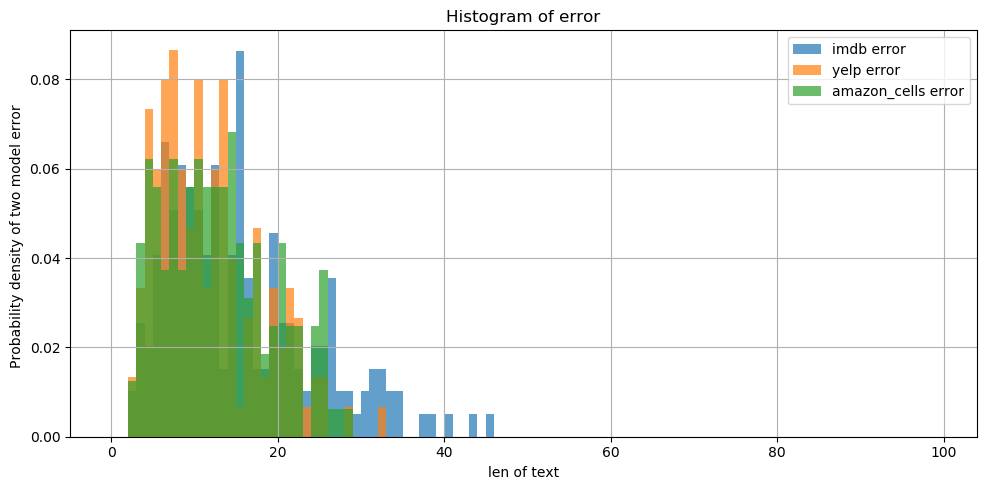

In [70]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

num_bins = range(0, 100, 1)
# the histogram of the data

tf_idf_model_result_0 = tf_idf_model_result.iloc[:1000]
tf_idf_model_result_1 = tf_idf_model_result.iloc[1000:2000]
tf_idf_model_result_2 = tf_idf_model_result.iloc[2000:]

ax.hist(tf_idf_model_result_0['text_len'][tf_idf_model_result_0['is_error'] == 1], 
        num_bins, density=1, label='imdb error', alpha=0.7)
ax.hist(tf_idf_model_result_1['text_len'][tf_idf_model_result_1['is_error'] == 1], 
        num_bins, density=1, label='yelp error', alpha=0.7)
ax.hist(tf_idf_model_result_2['text_len'][tf_idf_model_result_2['is_error'] == 1], 
        num_bins, density=1, label='amazon_cells error', alpha=0.7)
ax.set_xlabel('len of text')
ax.set_ylabel('Probability density of two model error ')
ax.set_title('Histogram of error')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

In [71]:
(tf_idf_model_result_0['is_error'] == 1).sum()

197

In [72]:
(tf_idf_model_result_1['is_error'] == 1).sum()

150

In [73]:
(tf_idf_model_result_2['is_error'] == 1).sum()

161

In [74]:
#tfidf model下 yelp data表現較好, imdb表現明顯較差

#### tf

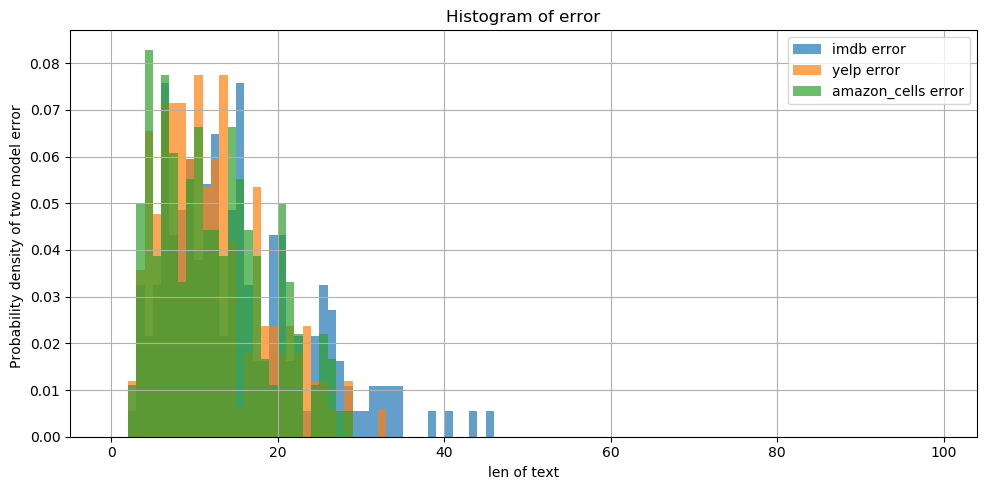

In [75]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

num_bins = range(0, 100, 1)
# the histogram of the data

tf_model_result_0 = tf_model_result.iloc[:1000]
tf_model_result_1 = tf_model_result.iloc[1000:2000]
tf_model_result_2 = tf_model_result.iloc[2000:]

ax.hist(tf_model_result_0['text_len'][tf_model_result_0['is_error'] == 1], 
        num_bins, density=1, label='imdb error', alpha=0.7)
ax.hist(tf_model_result_1['text_len'][tf_model_result_1['is_error'] == 1], 
        num_bins, density=1, label='yelp error', alpha=0.7)
ax.hist(tf_model_result_2['text_len'][tf_model_result_2['is_error'] == 1], 
        num_bins, density=1, label='amazon_cells error', alpha=0.7)
ax.set_xlabel('len of text')
ax.set_ylabel('Probability density of two model error ')
ax.set_title('Histogram of error')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

In [76]:
(tf_model_result_0['is_error'] == 1).sum()

185

In [77]:
(tf_model_result_1['is_error'] == 1).sum()

168

In [78]:
(tf_model_result_2['is_error'] == 1).sum()

181

In [79]:
#tfidf model下 yelp表現較好, imdb和amazon表現較差

In [80]:
#電影評論常常是將劇情、演員和配樂等不同元素分開評論，因此語意較複雜，精準度較差是可以被預估的